In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import pylab as pl
import scipy.stats as st
import seaborn as sns
import pandas as pd
import detection as dtc
import fitting
import emission
from constants import *
import cross_sections as cs
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import gamma
from scipy.integrate import simps, simpson
from tqdm import tqdm
import os
from sklearn.metrics import r2_score
from random import choices
import pickle


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
E = np.linspace(5, 100, 500) # Neutrino detection energy
detector = 'Hyper-k'
targets = (216e9/18.01528)*6.022e23*2
EOS = 'LS220-27.0'
hierarchy = 'inverted'

In [4]:
L_true = np.sum(params[EOS][-3:])

In [5]:
detection_nue = dtc.detection_spectra(E, EOS, 'nu_e', detector, hierarchy, 5, get_directions = False)
detection_nubare = dtc.detection_spectra(E, EOS, 'nubar_e', detector, hierarchy, 5, get_directions = False)
detection_nux = dtc.detection_spectra(E, EOS, 'nu_x', detector, hierarchy, 5, get_directions = False)

In [6]:
detection = detection_nue + detection_nubare + detection_nux

In [7]:
npoints = 500
Enu_list = E.copy()
Edec = {}
for i in range(15):
    Edec[i] = np.linspace(7*i, 7*(i+1), npoints)

In [8]:
d=[]
ddec = {}
for i in range(len(Edec)):
    ddec[i] = []

In [9]:
for i in tqdm(range(len(Enu_list))):
    E_nu = Enu_list[i]
    dd = 0
    for j in range(len(Edec)):
        dd += simpson(detection[i]*dtc.resolution_detector(Edec[j],E_nu,detector),Edec[j])
        ddec[j].append(dd)
    d.append(dd)

100%|██████████| 500/500 [00:01<00:00, 334.22it/s]


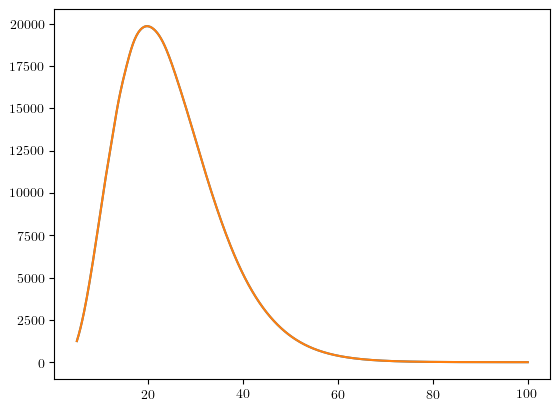

In [10]:
# for i in range(20):
#     plt.plot(Edec[i], ddec[i], label=fr'$n_{i}(E_\nu)$')
plt.plot(E, detection)
plt.plot(Enu_list, d)
plt.show()

In [11]:
enubin = []
for i in range(15):
    enubin.append([7*i, 7*(i+1)])
    
enubin = np.array(enubin).flatten()

In [12]:
bins=np.array([[simpson(ddec[i],Enu_list), simpson(ddec[i],Enu_list)] for i in range(len(Edec))])

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [13]:
bins = np.concatenate((bins[:1,:], bins[1:,:]-bins[:-1,:]))
bins = bins.flatten()

values = bins[range(0, len(bins), 2)]

In [14]:
positions = (enubin[1:] + enubin[:-1])[range(0, len(bins), 2)]/2

In [15]:
f = fitting.fitting_spectra

In [16]:
def fitting_spectra(x, alpha, E_mean):
    """
    Shape of the detection spectrum
    """
################################ DUNE
    channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                    'numubar_e','nc_nue_O16','nc_nuebar_O16']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
    cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
    cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
    cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
    # Total cross section
    nue_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38
    nubare_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38# + cs_nc_nuebar_O16(x)*x*1e-38
    nux_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
    total_cross = nue_cross + nubare_cross + 4*nux_cross
    # Detector efficiency
    eff = np.where(x<4.5,0,0.9)
    # Combined spectrum
    spectrum = fitting.spectrum_shape(x, alpha, E_mean)
    all = spectrum*total_cross*eff
    # Normalization
    A = simps(all, x)
    return all/A

def fitting_spectra_not_norm(x, alpha, E_mean):
    """
    Shape of the detection spectrum
    """
################################ DUNE
    channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                    'numubar_e','nc_nue_O16','nc_nuebar_O16']
    xs_data = cs.snowglobes(channels)

    # All these cross sections are in units of 10⁻³⁸ cm²/MeV
    cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
    cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
    cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
    cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
    cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
    cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
    cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
    cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
    cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
    # Total cross section
    nue_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38
    nubare_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38# + cs_nc_nuebar_O16(x)*x*1e-38
    nux_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
    total_cross = nue_cross + nubare_cross + 4*nux_cross
    # Detector efficiency
    eff = np.where(x<4.5,0,0.9)
    # Combined spectrum
    spectrum = fitting.spectrum_shape(x, alpha, E_mean)
    all = spectrum*total_cross*eff
    # Normalization
    return all

In [17]:
ref = dtc.energy_sampler(E, EOS, detector, hierarchy, 5, get_directions = False)


Number of expected neutrinos by flavor at 5 kpc (Hyper-k)

electron neutrinos: 131630
electron antineutrinos: 353577
mu/tau (anti)neutrinos: 2030


In [18]:
# y, bins = np.histogram(ref['Energy_Total'], bins = [7*i for i in range(16)], density = True) # Super/Hyper-K
y, bins = np.histogram(ref['Energy_Total'], bins = [7*i for i in range(15)], density = True)

In [19]:
x = (bins[:-1] + bins[1:])/2

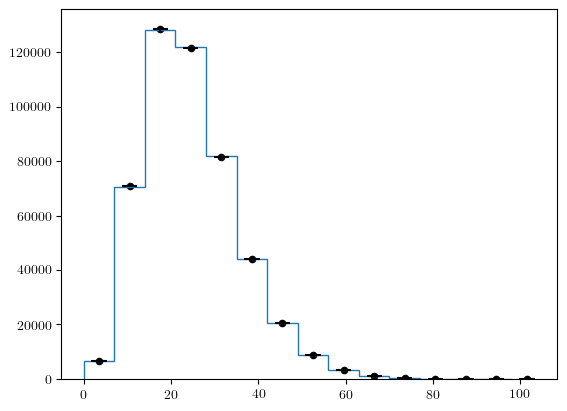

In [20]:
# plt.plot(x, y)
plt.hist(ref['Energy_Total'], bins = [7*i for i in range(15)], histtype = 'step')
plt.scatter(positions, values, s = 20, color = 'black')
plt.errorbar(positions, values, yerr = 2*np.sqrt(values), xerr = 1.75,
            fmt = 'none', color = 'black')
plt.show()

In [21]:
c, cov = curve_fit(fitting_spectra, x, y, bounds = ([0,0],[5, 20]))

In [22]:
print(f'Fitted pinch parameter: {c[0]:.3f} +/- {np.sqrt(cov[0,0]):.3f} \n Fitted mean energy: {c[1]:.3f} +/- {np.sqrt(cov[1,1]):.3f}')

Fitted pinch parameter: 1.718 +/- 0.105 
 Fitted mean energy: 13.121 +/- 0.232


In [23]:
curves = []

E = np.linspace(0, 100, 10000)

for i in tqdm(range(100)):
    a = np.random.normal(c[0], np.sqrt(cov[0,0]))
    b = np.random.normal(c[1], np.sqrt(cov[1,1]))
    
    curves.append(fitting_spectra(E, a, b))
    
curves = np.array(curves)

100%|██████████| 100/100 [00:04<00:00, 20.43it/s]


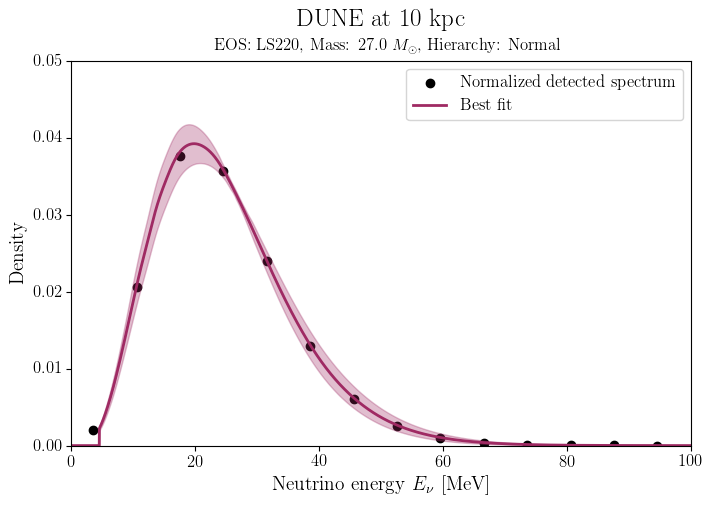

In [24]:
E = np.linspace(0, 100, 10000)

fig, ax = plt.subplots(figsize = (8,5))
# plt.plot(x, y, lw = 2, color = 'black')
plt.scatter(x, y, color = 'black', label = 'Normalized detected spectrum')
plt.plot(E, fitting_spectra(E, *c), color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
# plt.plot(x, np.mean(curves, axis = 0), color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
plt.fill_between(E, np.percentile(curves, 2.5, axis = 0),
                 np.percentile(curves, 97.5, axis = 0),
                 color = sns.color_palette('inferno')[2], alpha = 0.3)
plt.xlim(0, 100)
plt.ylim(0, 0.05)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(r'Neutrino energy $E_\nu$ [MeV]', fontsize = 14)
plt.ylabel(r'Density', fontsize = 14)
plt.title(r'DUNE at 10 kpc', fontsize = 18, pad = 24)
fig.text(0.52, 0.9, r'EOS: LS220, Mass: 27.0 $M_{\odot}$, Hierarchy: Normal', fontsize = 12, ha = 'center')
plt.legend(loc = 'upper right', fontsize = 12)

fig.patch.set_alpha(0.3)
for ax in fig.axes:
    ax.patch.set_alpha(0.7)

plt.show()

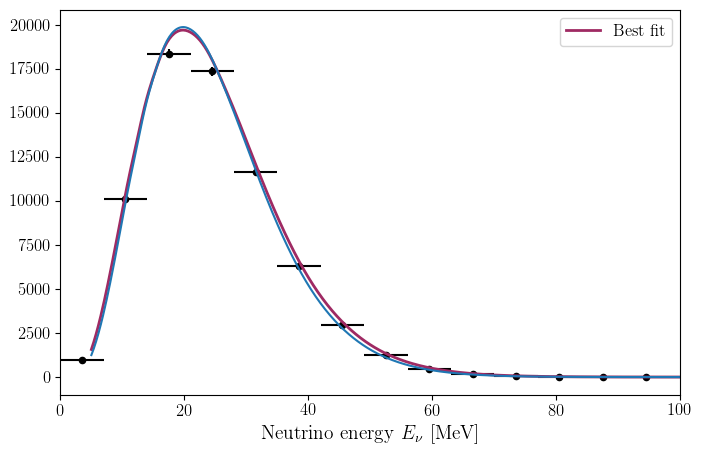

In [36]:
E = np.linspace(5, 100, 500)

fig, ax = plt.subplots(figsize = (8,5))
plt.scatter(positions, values/7, s = 20, color = 'black')
plt.errorbar(positions, values/7, yerr = 2*np.sqrt(values/7), xerr = 3.5,
            fmt = 'none', color = 'black')
plt.plot(E, (L_true*targets*6.2415e5*0.35/(4*np.pi*(5*3.086e21)**2))*fitting_spectra_not_norm(E, *c),
         color = sns.color_palette('inferno')[2], lw = 2, label = 'Best fit')
plt.plot(E, detection)

plt.xlim(0, 100)
# plt.ylim(0, 0.05)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(r'Neutrino energy $E_\nu$ [MeV]', fontsize = 14)
plt.legend(loc = 'upper right', fontsize = 12)

fig.patch.set_alpha(0.3)
for ax in fig.axes:
    ax.patch.set_alpha(0.7)

plt.show()

In [26]:
len(ref['Energy_Total'])

487598

In [27]:
simps(detection, E)

487237.20650910435

In [28]:
simps((L_true*targets*6.2415e5*0.45/(4*np.pi*(5*3.086e21)**2))*fitting_spectra_not_norm(E, *c), E)

644747.7306466675

In [29]:
def spectrum_shape(x, alpha, E_mean):
    """
    Overral shape of the emission spectrum
    """
    A = ((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    f_nu = A*(x**alpha)*np.exp(-(alpha + 1)*x/E_mean)
    return f_nu

In [30]:
channels = ['ibd','nue_e','nuebar_e','nue_O16','nuebar_O16','numu_e',
                    'numubar_e','nc_nue_O16','nc_nuebar_O16']
xs_data = cs.snowglobes(channels)

# All these cross sections are in units of 10⁻³⁸ cm²/MeV
cs_ibd = interp1d(1e3*(10**(xs_data[0][0])), xs_data[0][4]/1e3, fill_value='extrapolate')
cs_nue_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[1][1]/1e3, fill_value='extrapolate')
cs_nuebar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[2][4]/1e3, fill_value='extrapolate')
cs_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[3][1]/1e3, fill_value='extrapolate')
cs_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[4][1]/1e3, fill_value='extrapolate')
cs_nux_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[5][2]/1e3, fill_value='extrapolate')
cs_nuxbar_e = interp1d(1e3*(10**(xs_data[0][0])), xs_data[6][5]/1e3, fill_value='extrapolate')
cs_nc_nue_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[7][1]/1e3, fill_value='extrapolate')
cs_nc_nuebar_O16 = interp1d(1e3*(10**(xs_data[0][0])), xs_data[8][4]/1e3, fill_value='extrapolate')
# Total cross section
nue_cross = cs_nue_e(x)*x*1e-38 + cs_nue_O16(x)*x*1e-38
nubare_cross = cs_nuebar_e(x)*x*1e-38 + cs_ibd(x)*x*1e-38 + cs_nuebar_O16(x)*x*1e-38# + cs_nc_nuebar_O16(x)*x*1e-38
nux_cross = cs_nux_e(x)*x*1e-38 + cs_nuxbar_e(x)*x*1e-38
total_cross = nue_cross + nubare_cross + 4*nux_cross

In [31]:
N_T = len(ref['Energy_Total'])

In [32]:
def R_th(M):
    M_sol = 1.989e30
    c = 2.98e8
    G = 6.67e-11
    return 2.9*M*M_sol*G/c**2

def R_sph(M):
    M_sol = 1.989e30
    return 10.4*((1000/716)**(2/3))*((M*M_sol/M_sol)**(1/3))

In [39]:
distance_large_uniform = []
distance_tight_uniform = []
distance_true = []

for j in tqdm(range(50000)):
    # Sampling neutron star mass
    m_ns = np.random.normal(1.33, 0.09)
    # Setting the radius
    radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
    # Calculating total luminosity
    L_large = 3.6e53*((m_ns/1.5)**2)*(10/radius)*6.2415e5
    # L = L_true*6.2415e5
    # L_large = np.random.uniform(1e53, 7e53)*6.2415e5
    L_tight = np.random.normal(3.1e53, 1e53)*6.2415e5
    # L = np.random.normal(L_true, 0.5e52)*6.2415e5
    factor = np.random.uniform(0.3, 0.4)
    L_eff_large = L_large*factor
    L_eff_tight = L_tight*factor
    L_eff_true = L_true*6.2415e5*factor
    # Calculating distance squared
    a = np.random.normal(c[0], np.sqrt(cov[0,0]))
    # a = np.random.normal(1.778, 0.002)
    b = np.random.normal(c[1], np.sqrt(cov[1,1]))
    # b = np.random.normal(12.667, 0.006)
    D_square_large = (L_eff_large/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*np.where(x<4.5,0,0.9)*total_cross, x)
    distance_large_uniform.append(np.sqrt(D_square_large)*3.2408e-22)
    D_square_tight = (L_eff_tight/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*np.where(x<4.5,0,0.9)*total_cross, x)
    distance_tight_uniform.append(np.sqrt(D_square_tight)*3.2408e-22)
    D_square_true = (L_eff_true/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*np.where(x<4.5,0,0.9)*total_cross, x)
    distance_true.append(np.sqrt(D_square_true)*3.2408e-22)

100%|██████████| 50000/50000 [00:27<00:00, 1824.21it/s]


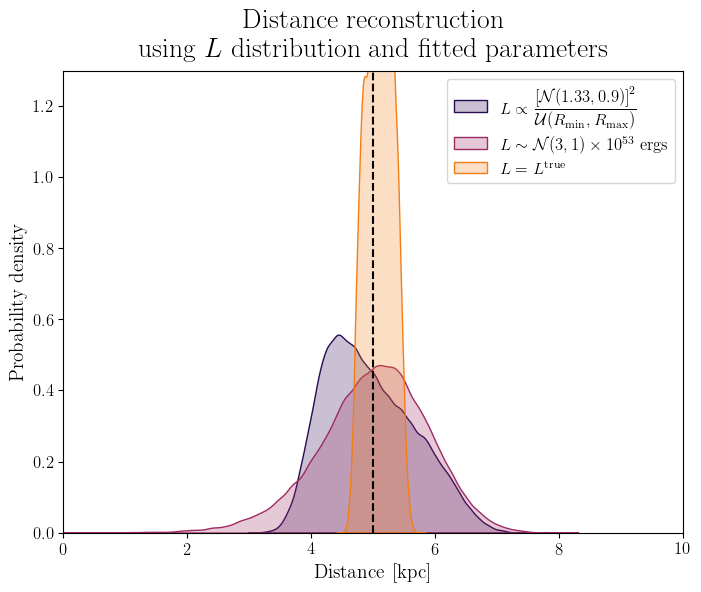

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
# plt.hist(distance, bins = [5 + i for i in range(40)], edgecolor = 'black', density = True)
sns.kdeplot(distance_large_uniform, fill = True, bw_adjust = 0.7, color = sns.color_palette('inferno')[0],
           label = r'$L \propto \displaystyle \frac{\left[\mathcal{N}(1.33, 0.9)\right]^2}{\mathcal{U}(R_{\mathrm{min}}, R_{\mathrm{max}})}$')

sns.kdeplot(distance_tight_uniform, fill = True, bw_adjust = 0.7, color = sns.color_palette('inferno')[2],
           label = r'$L \sim \mathcal{N}(3, 1) \times 10^{53}$ ergs')
sns.kdeplot(distance_true, fill = True, bw_adjust = 0.7, color = sns.color_palette('inferno')[4],
           label = r'$L = L^{\mathrm{true}}$')
plt.axvline(5, ls = '--', color = 'black')
plt.xlim(0, 10)
plt.xlabel('Distance [kpc]', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylim(0, 1.3)
plt.ylabel('Probability density', fontsize = 14)
plt.yticks(fontsize = 12)
plt.legend(loc = 'upper right', fontsize = 12)
# plt.hlines(0.93, 13.8, 14.8, ls = '--', color = 'black')
# plt.text(15, 0.93, '$D^{\mathrm{true}}$', fontsize = 12, va = 'center')
plt.title('Distance reconstruction \n using $L$ distribution and fitted parameters',
          fontsize = 20, pad = 10)
# plt.text(10.7, 0.4, '$D = $' + f' {np.median(distance_true):.1f} (95\% CI: {np.percentile(distance_true, 2.5):.1f} - {np.percentile(distance_true, 97.5):.1f})',
#          fontsize = 12, va = 'center')
# plt.text(11.3, 0.24, '$D = $' + f' {np.nanmedian(distance_tight_uniform):.1f} (95\% CI: {np.nanpercentile(distance_tight_uniform, 2.5):.1f} - {np.nanpercentile(distance_tight_uniform, 97.5):.1f})',
#          fontsize = 12, va = 'center')
# plt.text(13.5, 0.15, '$D = $' + f' {np.median(distance_large_uniform):.1f} (95\% CI: {np.percentile(distance_large_uniform, 2.5):.1f} - {np.percentile(distance_large_uniform, 97.5):.1f})',
#          fontsize = 12, va = 'center')
# plt.savefig(f'Plots/Distance_reconstruction_Hyper-K_perfect_resolution_{EOS}_{hierarchy}.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'Plots/Distance_reconstruction_Hyper-K_perfect_resolution_{EOS}_{hierarchy}.svg',
#             dpi = 300, bbox_inches = 'tight')
plt.show()

In [7]:
D_trues = np.concatenate(([1], [2*i for i  in range(1,51)]))

In [56]:
hierarchy

'inverted'

In [41]:
params = {}
params['Alpha_best'] = {}
params['E_mean_best'] = {}
params['Alpha_std'] = {}
params['E_mean_std'] = {}
params['Distance_rec_norm'] = {}
params['Distance_rec_uni'] = {}
params['Distance_rec_Ltrue'] = {}
params['Distance_true'] = D_trues

for i in range(len(D_trues)):
# for i in tqdm(range(1)):
    D = D_trues[i]
    print(f'Detector Hyper-K... Distance {D} kpc')
    params['Alpha_best'][D] = []
    params['E_mean_best'][D] = []
    params['Alpha_std'][D] = []
    params['E_mean_std'][D] = []
    params['Distance_rec_norm'][D] = []
    params['Distance_rec_uni'][D] = []
    params['Distance_rec_Ltrue'][D] = []
    for j in tqdm(range(5)):
        ref = dtc.energy_sampler(E, EOS, detector, hierarchy, D, get_directions = False,
                                 print_expected = False)
        y, bins = np.histogram(ref['Energy_Total'], bins = [7*i for i in range(15)], density = True)
        x = (bins[:-1] + bins[1:])/2

        c, cov = curve_fit(fitting_spectra, x, y, bounds = ([0,0],[5, 20]))

        params['Alpha_best'][D].append(c[0])
        params['E_mean_best'][D].append(c[1])
        params['Alpha_std'][D].append(np.sqrt(cov[0,0]))
        params['E_mean_std'][D].append(np.sqrt(cov[1,1]))
        
        N_T = len(ref['Energy_Total'])
        
        distance_large_uniform = []
        distance_tight_uniform = []
        distance_true = []

        for k in range(1000):
            # Sampling neutron star mass
            m_ns = np.random.normal(1.33, 0.09)
            # Setting the radius
            radius = np.random.uniform(R_th(m_ns)/1000, R_sph(m_ns))
            # Calculating total luminosity
            L_large = 3.6e53*((m_ns/1.5)**2)*(10/radius)*6.2415e5
            # L = L_true*6.2415e5
            # L_large = np.random.uniform(1e53, 7e53)*6.2415e5
            L_tight = np.random.normal(3.1e53, 1e53)*6.2415e5
            # L = np.random.normal(L_true, 0.5e52)*6.2415e5
            factor = np.random.uniform(0.3, 0.4)
            L_eff_large = L_large*factor
            L_eff_tight = L_tight*factor
            L_eff_true = L_true*6.2415e5*factor
            # Calculating distance squared
            a = np.random.normal(c[0], np.sqrt(cov[0,0]))
            # a = np.random.normal(1.778, 0.002)
            b = np.random.normal(c[1], np.sqrt(cov[1,1]))
            # b = np.random.normal(12.667, 0.006)
            D_square_large = (L_eff_large/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*np.where(x<4.5,0,0.9)*total_cross, x)
            distance_large_uniform.append(np.sqrt(D_square_large)*3.2408e-22)
            D_square_tight = (L_eff_tight/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*np.where(x<4.5,0,0.9)*total_cross, x)
            distance_tight_uniform.append(np.sqrt(D_square_tight)*3.2408e-22)
            D_square_true = (L_eff_true/(4*np.pi*N_T))*targets*simps(fitting.spectrum_shape(x, a, b)*np.where(x<4.5,0,0.9)*total_cross, x)
            distance_true.append(np.sqrt(D_square_true)*3.2408e-22)
            
        params['Distance_rec_norm'][D].append(distance_large_uniform)
        params['Distance_rec_uni'][D].append(distance_tight_uniform)
        params['Distance_rec_Ltrue'][D].append(distance_true)

  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 1 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 2 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 4 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 6 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 8 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 10 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 12 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 14 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 16 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 18 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 20 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 22 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 24 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 26 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 28 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 30 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 32 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 34 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 36 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 38 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 40 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 42 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 44 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 46 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 48 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 50 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 52 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 54 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 56 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 58 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 60 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 62 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 64 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 66 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 68 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 70 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 72 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 74 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 76 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 78 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 80 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 82 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 84 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 86 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 88 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 90 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 92 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 94 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 96 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 98 kpc


  0%|          | 0/5 [00:00<?, ?it/s]

Detector Hyper-K... Distance 100 kpc


100%|██████████| 5/5 [1:22:58<00:00, 995.78s/it] 


In [42]:
# save dictionary to person_data.pkl file
with open('Data/Parameters_Hyper-K_1-100kpc_IH_LS220-27.0.pkl', 'wb') as fp:
    pickle.dump(params, fp)

In [4]:
with open('Data/Parameters_Hyper-K_1-100kpc_NH_LS220-27.0.pkl', 'rb') as fp:
    params = pickle.load(fp)

In [5]:
means_D_norm = []
medians_D_norm = []
sigma1_D_norm = []
sigma2_D_norm = []
sigma3_D_norm = []

for D in params['Distance_rec_norm']:
    means_D_norm.append(np.nanmean(np.array(params['Distance_rec_norm'][D]).flatten()))
    medians_D_norm.append(np.nanmedian(np.array(params['Distance_rec_norm'][D]).flatten()))
    sigma1_D_norm.append([np.nanpercentile(np.array(params['Distance_rec_norm'][D]).flatten(), 16), np.nanpercentile(np.array(params['Distance_rec_norm'][D]).flatten(), 84)])
    sigma2_D_norm.append([np.nanpercentile(np.array(params['Distance_rec_norm'][D]).flatten(), 2.5), np.nanpercentile(np.array(params['Distance_rec_norm'][D]).flatten(), 97.5)])
    sigma3_D_norm.append([np.nanpercentile(np.array(params['Distance_rec_norm'][D]).flatten(), 0.2), np.nanpercentile(np.array(params['Distance_rec_norm'][D]).flatten(), 99.8)])
    
means_D_norm = np.array(means_D_norm)
medians_D_norm = np.array(medians_D_norm)
sigma1_D_norm = np.array(sigma1_D_norm)
sigma2_D_norm = np.array(sigma2_D_norm)
sigma3_D_norm = np.array(sigma3_D_norm)

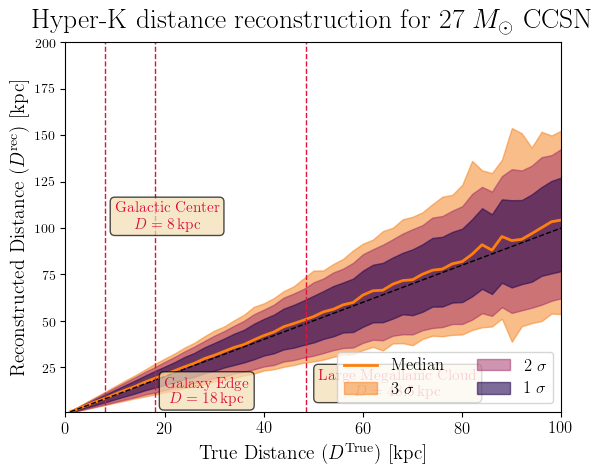

In [11]:
plt.plot(D_trues[:len(means_D_norm)], medians_D_norm, lw = 2, color = 'C1',
        label = 'Median')
plt.fill_between(D_trues[:len(means_D_norm)], sigma3_D_norm[:,0],
                 sigma3_D_norm[:,1], alpha = 0.5, color = sns.color_palette('inferno')[4],
                label = r'3 $\sigma$')
plt.fill_between(D_trues[:len(means_D_norm)], sigma2_D_norm[:,0],
                 sigma2_D_norm[:,1], alpha = 0.5, color = sns.color_palette('inferno')[2],
                label = r'2 $\sigma$')
plt.fill_between(D_trues[:len(means_D_norm)], sigma1_D_norm[:,0],
                 sigma1_D_norm[:,1], alpha = 0.6, color = sns.color_palette('inferno')[0],
                label = r'1 $\sigma$')
plt.plot(D_trues[:len(means_D_norm)], D_trues[:len(means_D_norm)], ls = '--', color = 'black', lw = 1)
plt.ylim(1, 200)
# plt.yscale('log')
plt.xlim(0, 100)
plt.axvline(48.5, lw = 1, ls = '--', color = 'crimson')
plt.text(67, 10, 'Large Megallanic Cloud \n $D = 48.5 \, \mathrm{kpc}$', fontsize = 11, color = 'crimson',
        bbox = dict(alpha = 0.7, facecolor = 'wheat', boxstyle = 'round'), ha = 'center')
plt.axvline(8, lw = 1, ls = '--', color = 'crimson')
plt.text(20.5, 100, 'Galactic Center \n $D = 8 \, \mathrm{kpc}$', fontsize = 11, color = 'crimson',
        bbox = dict(alpha = 0.7, facecolor = 'wheat', boxstyle = 'round'), ha = 'center')
plt.axvline(18, lw = 1, ls = '--', color = 'crimson')
plt.text(28.5, 6, 'Galaxy Edge \n $D = 18 \, \mathrm{kpc}$', fontsize = 11, color = 'crimson',
        bbox = dict(alpha = 0.7, facecolor = 'wheat', boxstyle = 'round'), ha = 'center')
plt.xlabel('True Distance ($D^{\mathrm{True}}$) [kpc]', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylabel('Reconstructed Distance ($D^{\mathrm{rec}}$) [kpc]', fontsize = 14)
# plt.yticks([1,10,100,500], labels = [1,10,100,500], fontsize = 12)
plt.title('Hyper-K distance reconstruction for 27 $M_\odot$ CCSN', fontsize = 20, pad = 10)
plt.legend(loc = 'lower right', fontsize = 12, ncol = 2)
# plt.savefig(f'Plots/Distance_reconstruction_varying_distance_{detector}_LS220-27.0_IH_norm_dist_larger_window.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'Plots/Distance_reconstruction_varying_distance_{detector}_LS220-27.0_IH_norm_dist_larger_window.svg',
#             dpi = 300, bbox_inches = 'tight')
plt.show()

In [9]:
d = 48
medians_D_norm[np.where(D_trues == d)[0][0]], sigma1_D_norm[np.where(D_trues == d)[0][0]], sigma2_D_norm[np.where(D_trues == d)[0][0]], sigma3_D_norm[np.where(D_trues == d)[0][0]]

((50.33748458393245+0j),
 array([37.00376691+0.j, 60.8943675 +0.j]),
 array([30.19064935+0.j, 67.1021175 +0.j]),
 array([27.41984394+0.j, 72.7863858 +0.j]))

In [ ]:
alphas = []
for D in params['Alpha_best']:
    alpha_temp = []
    for j in range(5):
        alpha_temp.append(np.random.normal(params['Alpha_best'][D][j], params['Alpha_std'][D][j], 200))
    alphas.append(np.vstack(alpha_temp).flatten())
    
E_means = []
for D in params['E_mean_best']:
    E_mean_temp = []
    for j in range(5):
        E_mean_temp.append(np.random.normal(params['E_mean_best'][D][j], params['E_mean_std'][D][j], 200))
    E_means.append(np.vstack(E_mean_temp).flatten())

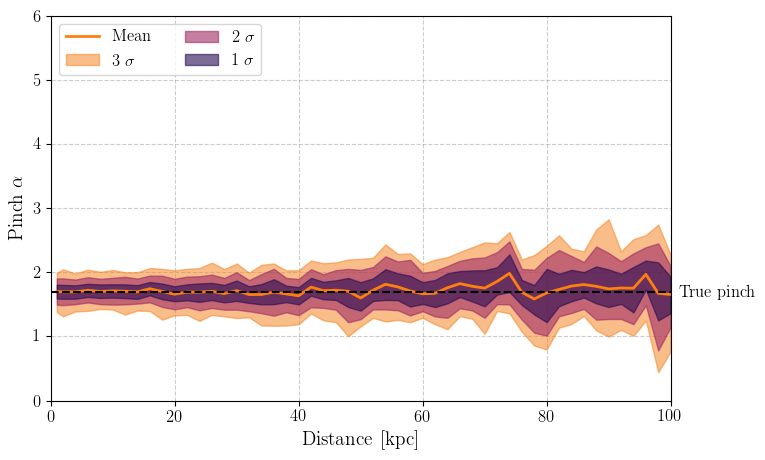

In [55]:
fig, ax = plt.subplots(figsize = (8,5))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', alpha = 0.4)
# plt.grid(True, alpha = 0.4, ls = '--', color = 'grey')
plt.plot(D_trues, np.mean(alphas, axis = 1), lw = 2, color = 'C1', label = 'Mean')
plt.fill_between(D_trues, np.percentile(alphas, 0.1, axis = 1), np.percentile(alphas, 99.9, axis = 1),
                alpha = 0.5, color = sns.color_palette('inferno')[4], label = r'3 $\sigma$')
plt.fill_between(D_trues, np.percentile(alphas, 2.5, axis = 1), np.percentile(alphas, 97.5, axis = 1),
                alpha = 0.6, color = sns.color_palette('inferno')[2], label = r'2 $\sigma$')
plt.fill_between(D_trues, np.percentile(alphas, 16, axis = 1), np.percentile(alphas, 84, axis = 1),
                alpha = 0.6, color = sns.color_palette('inferno')[0], label = r'1 $\sigma$')
plt.axhline(1.7, lw = 1.5, ls = '--', color = 'black')
# plt.axhline(1.2*1.2, lw = 1.5, ls = 'dotted', color = 'black')
# plt.axhline(1.2*0.8, lw = 1.5, ls = 'dotted', color = 'black')
plt.legend(loc = 'upper left', fontsize = 12, ncol = 2)
plt.ylim(0, 6)
plt.xlim(0, 100)
plt.xticks(fontsize = 12)
plt.xlabel('Distance [kpc]', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel(r'Pinch $\alpha$', fontsize = 14)
fig.text(0.91, 0.315, 'True pinch', fontsize = 12)
plt.savefig(f'Plots/Pinch_reconstruct_vary_distance_{detector}_LS220-27.0_IH.png', dpi = 300, bbox_inches = 'tight')
plt.savefig(f'Plots/Pinch_reconstruct_vary_distance_{detector}_LS220-27.0_IH.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [70]:
D_trues[np.where((np.percentile(alphas, 0.1, axis = 1) < 1.2*0.8) | (np.percentile(alphas, 99.9, axis = 1) > 1.2*1.2))[0][0]]

1

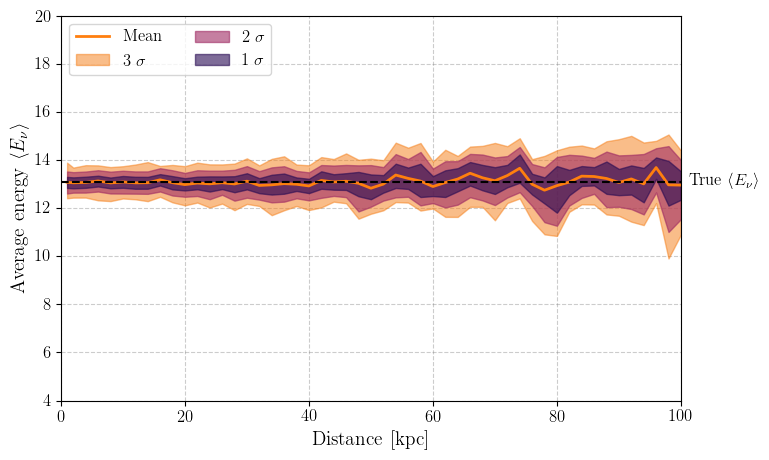

In [53]:
fig, ax = plt.subplots(figsize = (8,5))
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', alpha = 0.4)
# plt.grid(True, alpha = 0.4, ls = '--', color = 'grey')
plt.plot(D_trues, np.mean(E_means, axis = 1), lw = 2, color = 'C1', label = 'Mean')
plt.fill_between(D_trues, np.percentile(E_means, 0.1, axis = 1), np.percentile(E_means, 99.9, axis = 1),
                alpha = 0.5, color = sns.color_palette('inferno')[4], label = r'3 $\sigma$')
plt.fill_between(D_trues, np.percentile(E_means, 2.5, axis = 1), np.percentile(E_means, 97.5, axis = 1),
                alpha = 0.6, color = sns.color_palette('inferno')[2], label = r'2 $\sigma$')
plt.fill_between(D_trues, np.percentile(E_means, 16, axis = 1), np.percentile(E_means, 84, axis = 1),
                alpha = 0.6, color = sns.color_palette('inferno')[0], label = r'1 $\sigma$')
plt.axhline(13.1, lw = 1.5, ls = '--', color = 'black')
# plt.axhline(10.68*1.2, lw = 1.5, ls = 'dotted', color = 'black')
# plt.axhline(10.68*0.8, lw = 1.5, ls = 'dotted', color = 'black')
# plt.axvline(10)
plt.legend(loc = 'upper left', fontsize = 12, ncol = 2)
plt.ylim(4, 20)
plt.xlim(0, 100)
plt.xticks(fontsize = 12)
plt.xlabel('Distance [kpc]', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel(r'Average energy $\left \langle E_\nu \right \rangle$', fontsize = 14)
fig.text(0.91, 0.54, r'True $\left \langle E_\nu \right \rangle$', fontsize = 12)
plt.savefig(f'Plots/E_mean_reconstruct_vary_distance_{detector}_LS220-27.0_IH.png', dpi = 300, bbox_inches = 'tight')
plt.savefig(f'Plots/E_mean_reconstruct_vary_distance_{detector}_LS220-27.0_IH.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [54]:
D_trues[np.where((np.percentile(E_means, 0.1, axis = 1) < 10.68*0.8) | (np.percentile(E_means, 99.9, axis = 1) > 10.68*1.2))[0][0]]

36